In [1]:
#1 User-Defined Inputs

# Set Watershed Files Directory
watershed_files_directory = r"Watershed_Files.AWS"

# Set buffer distance and get filtered stations
buffer_distance_miles = 100

# Define the date range for filtering
timeperiod_start = "2000-01-01"
timeperiod_end = "2022-12-31"

# GHNCD Data Download (NOAA site can be slow/unavailable)
# Turn on first time to get wide search area, then disable
download_station_data = "Yes"    # "Yes" or "No"

# Parameters
concurrent_downloads = 1

#Exclusion List to remove stations with bad data
exclude_stations_by_name = []

In [2]:
#2 Install the required libraries

# Install/Import Required Python Packages
import sys
import subprocess
import os
os.environ['USE_PATH_FOR_GDAL_PYTHON'] = 'YES'

# Based on the import statements below, create a List of packages you want to ensure are installed
packages = ["os", "shutil", "pandas", "geopandas", "subprocess", "shapely", "csv", "concurrent.futures", "dask", "netCDF4", "xarray", "bs4", "tables", "requests", "numba", "matplotlib"]

# Logic to Install Packages
def install(package):
    try:
        # Attempt to install using pip
        print(f"Attempting to install {package} using pip")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Installed {package} successfully using pip")
    except subprocess.CalledProcessError:
        try:
            # If pip fails, try to install using conda
            print(f"Attempting to install {package} using conda")
            subprocess.check_call(["conda", "install", "-c", "conda-forge", package])
        except subprocess.CalledProcessError:
            print(f"Failed to install {package} using both pip and conda")

for package in packages:
    try:
        # If the import succeeds, the package is installed, so we can move on
        __import__(package)
    except ImportError:
        # If the import fails, the package is not installed and we try to install it
        install(package)


# Import All Required Libraries for Script
import concurrent.futures
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
from io import StringIO
from math import radians, sin, cos, sqrt, atan2
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from shapely.geometry import Point 
from shapely.ops import unary_union
import numpy as np
import json
from IPython.display import clear_output
import xarray as xr
import subprocess
import sys
import platform
from numba import jit
import numba
import csv
import dask.array as da

def download_and_install_wheel(wheel_url):
    wheel_file = wheel_url.split("/")[-1]
    response = requests.get(wheel_url)
    
    if response.status_code == 200:
        with open(wheel_file, 'wb') as f:
            f.write(response.content)
        subprocess.check_call([sys.executable, "-m", "pip", "install", wheel_file])
        print(f"Successfully installed GDAL from {wheel_file}.")
    else:
        print(f"Failed to download {wheel_file}. HTTP Status Code: {response.status_code}")

# Try importing the ogr module
try:
    from osgeo import ogr
    print("Successfully imported ogr from osgeo.")
except ImportError:
    print("Failed to import ogr from osgeo. Attempting to download and install GDAL wheel...")
    
    # Get Python version and system architecture
    python_version = f"cp{sys.version_info.major}{sys.version_info.minor}"
    arch = 'win_amd64' if platform.architecture()[0] == '64bit' else 'win32'
    
    # Generate the wheel URL dynamically
    wheel_url = f"https://download.lfd.uci.edu/pythonlibs/archived/GDAL-3.4.3-{python_version}-{python_version}-{arch}.whl"
    
    download_and_install_wheel(wheel_url)
    
    # Re-try importing the ogr module
    try:
        from osgeo import ogr
        print("Successfully imported ogr from osgeo.")
    except ImportError:
        print("Still unable to import ogr from osgeo after attempting to install. Please check your environment.")


from osgeo import ogr



Successfully imported ogr from osgeo.


In [3]:
#3 Define all paths


# Find .shp file within watershed_files_directory and set as watershed_boundary_shapefile
import os
for file in os.listdir(watershed_files_directory):
    if file.endswith(".shp"):
        watershed_boundary_shapefile = os.path.join(watershed_files_directory, file)
        print(watershed_boundary_shapefile)
    else:
        pass
    



def ensure_directory_exists(directory_path: str) -> None:
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Created folder at: {directory_path}")
    else:
        print(f"Folder already exists at: {directory_path}")

watershed_boundary_shapefile_dir = os.path.dirname(watershed_boundary_shapefile)

# 1. Define base directories and paths
output_folder = os.path.dirname(watershed_boundary_shapefile)
ensure_directory_exists(output_folder)
print("Output Folder:", output_folder)

# 2. Paths related to global-historical-climatology-network-daily
subfolder_path = os.path.join(output_folder, "global-historical-climatology-network-daily")
ensure_directory_exists(subfolder_path)
print("global-historical-climatology-network-daily Path:", subfolder_path)

# 3. Paths related to index files
index_folder_path = os.path.join(output_folder, "index-files")
index_file_path = os.path.join(index_folder_path, "index.html")
csv_links_file_path = os.path.join(index_folder_path, "parsed_links.json")
ensure_directory_exists(index_folder_path)
print("Index File Path:", index_file_path)
print("CSV Links File Path:", csv_links_file_path)

# 4. Paths related to CSV and IDW_Grids
csv_folder_path = os.path.join(watershed_boundary_shapefile_dir, "global-historical-climatology-network-daily")


# 5. Paths related to CSV Precipitation Outputs
csv_precipitation_folder_path = os.path.join(watershed_boundary_shapefile_dir, "CSV_Precipitation")
csv_precipitation_file_path = os.path.join(csv_precipitation_folder_path, "Precipitation.csv")
ensure_directory_exists(csv_precipitation_folder_path)




Watershed_Files.AWS\WF_Boundary_Simple.shp
Folder already exists at: Watershed_Files.AWS
Output Folder: Watershed_Files.AWS
Created folder at: Watershed_Files.AWS\global-historical-climatology-network-daily
global-historical-climatology-network-daily Path: Watershed_Files.AWS\global-historical-climatology-network-daily
Created folder at: Watershed_Files.AWS\index-files
Index File Path: Watershed_Files.AWS\index-files\index.html
CSV Links File Path: Watershed_Files.AWS\index-files\parsed_links.json
Created folder at: Watershed_Files.AWS\CSV_Precipitation


In [4]:
#3 Download ghcnd-stations.txt from AWS

import os
import pandas as pd
from io import StringIO
import requests

# Extracting directory from user-specified shapefile path
watershed_dir = os.path.dirname(watershed_boundary_shapefile)

# Constructing new path for "ghcnd-stations.txt"
index_files_dir = os.path.join(watershed_dir, 'index-files')
os.makedirs(index_files_dir, exist_ok=True)  # Ensure the directory exists
file_path = os.path.join(index_files_dir, "ghcnd-stations.txt")

# Check if the file already exists
if not os.path.exists(file_path):
    # AWS URL to the text file
    aws_url = "http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt"

    # Download and save the file from AWS
    try:
        response = requests.get(aws_url)
        response.raise_for_status()
        with open(file_path, "w", encoding='utf-8') as file:
            file.write(response.text)
        print("Downloaded ghcnd-stations.txt from AWS.")
        data = response.text  # Assign the content to data
    except requests.RequestException as e:
        print(f"Failed to download from AWS due to: {e}")
else:
    print("ghcnd-stations.txt already exists. Using the existing file.")
    # Read the file into data
    with open(file_path, "r", encoding='utf-8') as file:
        data = file.read()

# Proceed only if data is not None
if data is not None:
    # Read the content into a Pandas DataFrame
    print("Reading data into DataFrame stations_df")
    stations_df = pd.read_fwf(StringIO(data), header=None, widths=[12, 9, 10, 7, 3, 31, 4, 4, 6])

    # Extract relevant data into separate columns
    stations_df['ID'] = stations_df[0]
    stations_df['Latitude'] = stations_df[1]
    stations_df['Longitude'] = stations_df[2]
    stations_df['Elevation'] = stations_df[3]
    stations_df['Name'] = stations_df[5]

    # Remove rows with NaN in 'Latitude' and 'Longitude'
    stations_df = stations_df.dropna(subset=['Latitude', 'Longitude'])

    # Drop columns 1-8 from stations_df
    stations_df = stations_df.drop(stations_df.columns[1:9], axis=1)

    # Display the first few rows of the DataFrame
    print(stations_df.head())
else:
    print("No data to process.")


# NEED TO ADD - OTHER DOCUMENTATION DOWNLOADED TO INDEX FILES FOLDER 
# https://docs.opendata.aws/noaa-ghcn-pds/readme.html
# http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
#
#



Downloaded ghcnd-stations.txt from AWS.
Reading data into DataFrame stations_df
             0           ID  Latitude  Longitude  Elevation   
0  ACW00011604  ACW00011604   17.1167   -61.7833       10.1  \
1  ACW00011647  ACW00011647   17.1333   -61.7833       19.2   
2  AE000041196  AE000041196   25.3330    55.5170       34.0   
3  AEM00041194  AEM00041194   25.2550    55.3640       10.4   
4  AEM00041217  AEM00041217   24.4330    54.6510       26.8   

                    Name  
0  ST JOHNS COOLIDGE FLD  
1               ST JOHNS  
2    SHARJAH INTER. AIRP  
3             DUBAI INTL  
4         ABU DHABI INTL  


Watershed Boundary CRS: 6479
Converting boundary_gdf to EPSG:4326


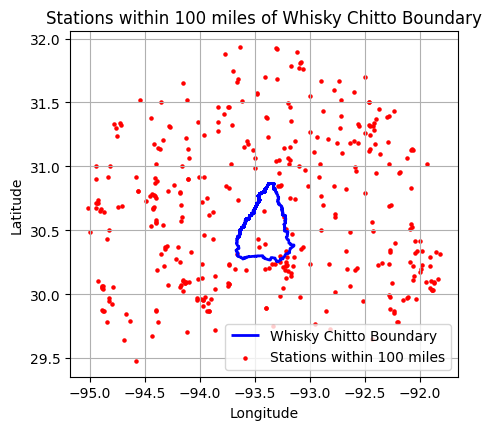

,0,ID,Latitude,Longitude,Elevation,Name,geometry,Distance
121237,USR0000TANA,USR0000TANA,29.6692,-94.4383,1.5,ANAHUAC NWR TEXAS,POINT (-94.43830 29.66920),84.346770
103704,USC00161425,USC00161425,29.7500,-93.3333,3.0,CAMERON,POINT (-93.33330 29.75000),52.247098
120730,USR0000LSAB,USR0000LSAB,29.8881,-93.4039,0.9,SABINE LOUISIANA,POINT (-93.40390 29.88810),42.512994
103816,USC00163979,USC00163979,29.8894,-93.4019,1.8,HACKBERRY 8 SSW,POINT (-93.40190 29.88940),42.424074
103817,USC00163981,USC00163981,29.9872,-93.2694,1.8,HACKBERRY 4NE,POINT (-93.26940 29.98720),36.615460


In [5]:
#4 Find Stations within watershed boundary and within buffer distance

# Load your boundary shapefile
# Ensure the file path is accurate
boundary_gdf = gpd.read_file(watershed_boundary_shapefile)

# Ensure the CRS is WGS 84
print("Watershed Boundary CRS: " + str(boundary_gdf.crs.to_epsg()))
print("Converting boundary_gdf to EPSG:4326")

if boundary_gdf.crs != "EPSG:4326":
    boundary_gdf = boundary_gdf.to_crs(epsg=4326)

# Ensure 'Latitude' and 'Longitude' are numeric
stations_df['Latitude'] = pd.to_numeric(stations_df['Latitude'], errors='coerce')
stations_df['Longitude'] = pd.to_numeric(stations_df['Longitude'], errors='coerce')

# Handle NaN values
if stations_df[['Latitude', 'Longitude']].isna().any().any():
    print("Warning: NaN values found in station coordinates. Removing these entries.")
    stations_df = stations_df.dropna(subset=['Latitude', 'Longitude'])

# Handle out-of-bound coordinates
if ((stations_df['Latitude'] < -90) | (stations_df['Latitude'] > 90) |
    (stations_df['Longitude'] < -180) | (stations_df['Longitude'] > 180)).any():
    print("Warning: Invalid coordinates found. Removing these entries.")
    stations_df = stations_df[(stations_df['Latitude'] >= -90) & (stations_df['Latitude'] <= 90) &
                              (stations_df['Longitude'] >= -180) & (stations_df['Longitude'] <= 180)]

# Convert stations data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(stations_df['Longitude'], stations_df['Latitude'])]
stations_gdf = gpd.GeoDataFrame(stations_df, geometry=geometry, crs="EPSG:4326")

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a)) 
    miles = 3959 * c
    return miles

# Filter stations function
def filter_stations(buffer_distance_miles):
    boundary_union = unary_union(boundary_gdf['geometry'])
    buffer_deg = buffer_distance_miles / (60 * 1.15)
    bbox = [boundary_union.bounds[0] - buffer_deg, boundary_union.bounds[1] - buffer_deg, 
            boundary_union.bounds[2] + buffer_deg, boundary_union.bounds[3] + buffer_deg]
    
    possible_matches_index = list(stations_gdf.sindex.intersection(bbox))
    possible_matches = stations_gdf.iloc[possible_matches_index].copy()
    
    possible_matches['Distance'] = possible_matches.apply(
        lambda row: haversine(row['Latitude'], row['Longitude'], 
                              boundary_union.centroid.y, boundary_union.centroid.x), axis=1)
    stations_within_buffer = possible_matches[possible_matches['Distance'] <= buffer_distance_miles]
    
    return stations_within_buffer


_filtered_df = filter_stations(buffer_distance_miles)

# Save results
_filtered_df.to_csv("stations_within_buffer.csv", index=False)

# Visualization
fig, ax = plt.subplots(figsize=(5, 5))
boundary_gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Whisky Chitto Boundary')

if not _filtered_df.empty and not _filtered_df.isna().any().any():
    _filtered_df.plot(ax=ax, marker='o', color='red', markersize=5, label=f'Stations within {buffer_distance_miles} miles')
else:
    print("Filtered data frame is empty or contains NaN values. Skipping plotting of stations.")
    
plt.legend()
plt.title(f'Stations within {buffer_distance_miles} miles of Whisky Chitto Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

display(_filtered_df.head())    




In [6]:
#6 Downloading Data for Filtered Stations
# Ensure _filtered_df is defined and contains the filtered station data

base_url = "http://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/"



# Lists to keep track of download results
successful_downloads = []
failed_downloads = []

# Global flag to control download termination across all threads
download_terminate = False


# Download the GHCND documentation PDF only if it doesn't already exist
doc_url = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf"
doc_file_path = os.path.join(index_folder_path, "GHCND_documentation.pdf")

if not os.path.exists(doc_file_path):
    try:
        doc_response = requests.get(doc_url, timeout=500)
        doc_response.raise_for_status()

        # Save the documentation file
        with open(doc_file_path, "wb") as file:
            file.write(doc_response.content)
        print("Downloaded GHCND documentation.")
    except requests.RequestException as e:
        print(f"Failed to download GHCND documentation due to: {str(e)}")
else:
    print("GHCND_documentation.pdf already exists, skipping download.")

# Function to download data for a given station
def download_station(station):
    global download_terminate
    
    file_path = os.path.join(subfolder_path, f"{station}.csv")  
    print(f"Downloading data for station: {station}")

    # Skip download if file already exists
    if os.path.exists(file_path):
        print(f"File for station {station} already exists. Skipping download.")
        successful_downloads.append(station)
        return
    
    # Using a session with retry mechanism
    session = requests.Session()
    retries = Retry(total=3, backoff_factor=1, status_forcelist=[502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    
    # Initial download attempt
    download_url = os.path.join(base_url, f"{station}.csv")
    print(f"data download url: {download_url}")
    
    try:
        response = session.get(download_url, timeout=20)
        response.raise_for_status()
        
        if download_terminate:
            return
        
        # Constructing new path for CSV files
        ghncd_dir = os.path.join(output_folder, 'global-historical-climatology-network-daily')  # Ensure CSVs go here
        os.makedirs(ghncd_dir, exist_ok=True)  # Ensure the directory exists

        # Assuming `file_name` is the name of the CSV file, adjust as needed
        file_path = os.path.join(ghncd_dir, f"{station}.csv")  # Ensure CSVs go here
        print(f"file_path: {file_path}")    
        
        # Save the data file
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded data for station: {station}")
        #Print file location
        print(f"File location: {file_path}")
        successful_downloads.append(station)
                
    except requests.RequestException as e:
        # Log failure and check for timeout
        if isinstance(e, requests.Timeout):
            download_terminate = True
            print(f"Timeout occurred: {str(e)}")
        else:
            print(f"Failed to retrieve data for station: {station} due to {str(e)}")
        failed_downloads.append(station)
        
# Download process
if download_station_data == 'Yes':
    with ThreadPoolExecutor(max_workers=concurrent_downloads) as executor:
        futures = {executor.submit(download_station, station): station for station in _filtered_df["ID"]}
        for future in as_completed(futures):
            if download_terminate:
                for f in futures:
                    f.cancel()
                print("Some downloads were cancelled due to a timeout.")
                break
else:
    print("Individual Station CSV Download disabled by user flag")

# Create DataFrames for successful and failed downloads
_downloaded_df = _filtered_df[_filtered_df["ID"].isin(successful_downloads)]
_failed_df = _filtered_df[_filtered_df["ID"].isin(failed_downloads)]

# clear_output()

print("Download process completed!  Re-run this cell to retry failed downloads.")





Downloaded GHCND documentation.
data download url: http://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/USR0000TANA.csv
file_path: Watershed_Files.AWS\global-historical-climatology-network-daily\USR0000TANA.csv
Downloaded data for station: USR0000TANA
File location: Watershed_Files.AWS\global-historical-climatology-network-daily\USR0000TANA.csv
data download url: http://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/USC00161425.csv
file_path: Watershed_Files.AWS\global-historical-climatology-network-daily\USC00161425.csv
Downloaded data for station: USC00161425
File location: Watershed_Files.AWS\global-historical-climatology-network-daily\USC00161425.csv
data download url: http://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/USR0000LSAB.csv
file_path: Watershed_Files.AWS\global-historical-climatology-network-daily\USR0000LSAB.csv
Downloaded data for station: USR0000LSAB
File location: Watershed_Files.AWS\global-historical-climatology-network-daily\USR0000LSAB.csv
data download url: http

In [7]:
#7 Parse the 'ghcnd-stations.txt' file to create a DataFrame with ID, Latitude, Longitude, Elevation, Name, and Geometry columns

def parse_ghcnd_stations(file_path):
    # Define column widths and names based on the GHCN-D documentation
    col_specs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, 68), (69, 73), (74, 75), (76, 79), (80, 85)]
    col_names = ['ID', 'Latitude', 'Longitude', 'Elevation', 'Name', 'GSN_Flag', 'HCN_CRN_Flag', 'WMO_ID', 'Method']

    # Read the file with fixed-width column formatting
    df = pd.read_fwf(file_path, colspecs=col_specs, header=None, names=col_names)

    return df


# Parse the 'ghcnd-stations.txt' file to create a DataFrame
ghcnd_stations_df = parse_ghcnd_stations(file_path)

# Optionally, display the first few rows of the DataFrame
print(ghcnd_stations_df.head())


            ID  Latitude  Longitude  Elevation                   Name   
0  ACW00011604   17.1167   -61.7833       10.1  ST JOHNS COOLIDGE FLD  \
1  ACW00011647   17.1333   -61.7833       19.2               ST JOHNS   
2  AE000041196   25.3330    55.5170       34.0    SHARJAH INTER. AIRP   
3  AEM00041194   25.2550    55.3640       10.4             DUBAI INTL   
4  AEM00041217   24.4330    54.6510       26.8         ABU DHABI INTL   

  GSN_Flag HCN_CRN_Flag WMO_ID   Method  
0      NaN          NaN    NaN      NaN  
1      NaN          NaN    NaN      NaN  
2        G            N    NaN  41196.0  
3      NaN          NaN    NaN  41194.0  
4      NaN          NaN    NaN  41217.0  


In [8]:
#8 Create a new dataframe for each AWS CSV file which was downloaded, focusing on precipitation data

# Initialize a dictionary to store the dataframes
dataframes_dict = {}

# Loop through each CSV file
for file_name in os.listdir(csv_folder_path):
    print(f"Loading data for station {file_name}")
    station_id = file_name.replace(".csv", "")
    file_path = os.path.join(csv_folder_path, file_name)

    try:
        # Load the AWS CSV data, suppressing the DtypeWarning
        aws_data = pd.read_csv(file_path, parse_dates=['DATE'], low_memory=False)
        
        # Filter for precipitation data (PRCP)
        prcp_data = aws_data[aws_data['ELEMENT'] == 'PRCP']

        # Merge with station details
        merged_data = pd.merge(prcp_data, ghcnd_stations_df, left_on='ID', right_on='ID')
        merged_data = merged_data[['ID', 'Name', 'DATE', 'Latitude', 'Longitude', 'DATA_VALUE']]
        merged_data.columns = ['STATION', 'NAME', 'DATE', 'LATITUDE', 'LONGITUDE', 'PRCP']

        # Add the dataframe to the dictionary
        dataframes_dict[station_id] = merged_data

    except Exception as e:
        print(f"Failed to load data for station {station_id} due to error: {str(e)}")
        continue



# Filter the dataframes based on the conditions (PRCP and date range)
print("Filtering dataframes based on conditions (PRCP and date range)")
filtered_dataframes_dict = {
    station_id: df 
    for station_id, df in dataframes_dict.items() 
    if ("PRCP" in df.columns) and
       (df['DATE'].min() <= pd.Timestamp(timeperiod_start) and df['DATE'].max() >= pd.Timestamp(timeperiod_end))
}

# Create a dataframe containing a list of all dataframes that meet the criteria
print("Creating a dataframe filtered_stations_df containing a list of all dataframes that meet the criteria")
filtered_stations_df = pd.DataFrame({
    "StationID": list(filtered_dataframes_dict.keys()),
    "MinDate": [df['DATE'].min() for df in filtered_dataframes_dict.values()],
    "MaxDate": [df['DATE'].max() for df in filtered_dataframes_dict.values()],
})

print("Filtered stations:")
display(filtered_stations_df.head())

# clear_output()

# Display each dataframe's StationID, Name, Lat, Long, and PRCP associated with filtered_stations_df for only the time period of interest
for station_id in filtered_stations_df["StationID"]:
    print(f"Station {station_id}:")
    # Ensuring 'PRCP' is in columns before attempting to display or process it
    if 'PRCP' in filtered_dataframes_dict[station_id].columns:
        display(filtered_dataframes_dict[station_id][["STATION", "NAME", "DATE", "LATITUDE", "LONGITUDE", "PRCP"]].head())
    else:
        print(f"No 'PRCP' column in DataFrame for station {station_id}.")


Loading data for station US1LAAC0001.csv
Loading data for station US1LAAC0002.csv
Loading data for station US1LAAC0003.csv
Loading data for station US1LAAC0006.csv
Loading data for station US1LAAL0003.csv
Loading data for station US1LAAV0001.csv
Loading data for station US1LAAV0003.csv
Loading data for station US1LAAV0005.csv
Loading data for station US1LABG0001.csv
Loading data for station US1LABG0002.csv
Loading data for station US1LABG0003.csv
Loading data for station US1LABG0004.csv
Loading data for station US1LACC0003.csv
Loading data for station US1LACC0005.csv
Loading data for station US1LACC0006.csv
Loading data for station US1LACC0009.csv
Loading data for station US1LACC0011.csv
Loading data for station US1LACC0014.csv
Loading data for station US1LACC0015.csv
Loading data for station US1LACC0016.csv
Loading data for station US1LACC0017.csv
Loading data for station US1LACC0018.csv
Loading data for station US1LACC0020.csv
Loading data for station US1LACC0021.csv
Loading data for

,StationID,MinDate,MaxDate
0,USC00160007,1891-02-02,2023-11-27
1,USC00160098,1892-06-01,2023-11-30
2,USC00160103,1992-01-01,2023-11-30
3,USC00160617,1973-04-01,2023-10-31
4,USC00161232,1976-01-01,2023-11-29


Station USC00160007:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00160007,LA ABBEVILLE,1891-02-02,29.9689,-92.1169,51
1,USC00160007,LA ABBEVILLE,1891-02-03,29.9689,-92.1169,20
2,USC00160007,LA ABBEVILLE,1891-02-06,29.9689,-92.1169,25
3,USC00160007,LA ABBEVILLE,1891-02-09,29.9689,-92.1169,64
4,USC00160007,LA ABBEVILLE,1891-02-12,29.9689,-92.1169,356


Station USC00160098:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00160098,LA ALEXANDRIA,1892-06-01,31.3206,-92.4611,157
1,USC00160098,LA ALEXANDRIA,1892-06-17,31.3206,-92.4611,107
2,USC00160098,LA ALEXANDRIA,1892-06-18,31.3206,-92.4611,104
3,USC00160098,LA ALEXANDRIA,1892-06-21,31.3206,-92.4611,3
4,USC00160098,LA ALEXANDRIA,1892-06-22,31.3206,-92.4611,51


Station USC00160103:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00160103,LA ALEXANDRIA 5 SSE,1992-01-01,31.2489,-92.4489,0
1,USC00160103,LA ALEXANDRIA 5 SSE,1992-01-02,31.2489,-92.4489,0
2,USC00160103,LA ALEXANDRIA 5 SSE,1992-01-03,31.2489,-92.4489,5
3,USC00160103,LA ALEXANDRIA 5 SSE,1992-01-04,31.2489,-92.4489,0
4,USC00160103,LA ALEXANDRIA 5 SSE,1992-01-05,31.2489,-92.4489,0


Station USC00160617:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00160617,LA BEAVER FIRE TWR,1973-04-01,30.7925,-92.4953,0
1,USC00160617,LA BEAVER FIRE TWR,1973-04-02,30.7925,-92.4953,0
2,USC00160617,LA BEAVER FIRE TWR,1973-04-03,30.7925,-92.4953,0
3,USC00160617,LA BEAVER FIRE TWR,1973-04-04,30.7925,-92.4953,0
4,USC00160617,LA BEAVER FIRE TWR,1973-04-05,30.7925,-92.4953,0


Station USC00161232:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00161232,LA BOYCE 3 WNW,1976-01-01,31.3944,-92.7164,0
1,USC00161232,LA BOYCE 3 WNW,1976-01-02,31.3944,-92.7164,124
2,USC00161232,LA BOYCE 3 WNW,1976-01-03,31.3944,-92.7164,0
3,USC00161232,LA BOYCE 3 WNW,1976-01-04,31.3944,-92.7164,0
4,USC00161232,LA BOYCE 3 WNW,1976-01-05,31.3944,-92.7164,0


Station USC00161287:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00161287,LA BUNKIE,1956-12-01,30.9594,-92.1786,0
1,USC00161287,LA BUNKIE,1956-12-02,30.9594,-92.1786,0
2,USC00161287,LA BUNKIE,1956-12-03,30.9594,-92.1786,0
3,USC00161287,LA BUNKIE,1956-12-04,30.9594,-92.1786,0
4,USC00161287,LA BUNKIE,1956-12-05,30.9594,-92.1786,0


Station USC00161535:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00161535,LA CARENCRO,1986-05-01,30.32,-92.0444,0
1,USC00161535,LA CARENCRO,1986-05-02,30.32,-92.0444,0
2,USC00161535,LA CARENCRO,1986-05-03,30.32,-92.0444,43
3,USC00161535,LA CARENCRO,1986-05-04,30.32,-92.0444,0
4,USC00161535,LA CARENCRO,1986-05-05,30.32,-92.0444,0


Station USC00162212:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00162212,LA CROWLEY 2 NE,1906-06-01,30.2408,-92.3478,0
1,USC00162212,LA CROWLEY 2 NE,1906-06-02,30.2408,-92.3478,0
2,USC00162212,LA CROWLEY 2 NE,1906-06-03,30.2408,-92.3478,0
3,USC00162212,LA CROWLEY 2 NE,1906-06-04,30.2408,-92.3478,0
4,USC00162212,LA CROWLEY 2 NE,1906-06-05,30.2408,-92.3478,0


Station USC00162641:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00162641,LA DRY CREEK 8NW,1994-09-01,30.7414,-93.1386,36
1,USC00162641,LA DRY CREEK 8NW,1994-09-02,30.7414,-93.1386,13
2,USC00162641,LA DRY CREEK 8NW,1994-09-03,30.7414,-93.1386,71
3,USC00162641,LA DRY CREEK 8NW,1994-09-04,30.7414,-93.1386,64
4,USC00162641,LA DRY CREEK 8NW,1994-09-05,30.7414,-93.1386,5


Station USC00163800:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00163800,LA GRAND COTEAU,1893-01-01,30.4183,-92.0442,0
1,USC00163800,LA GRAND COTEAU,1893-01-02,30.4183,-92.0442,0
2,USC00163800,LA GRAND COTEAU,1893-01-03,30.4183,-92.0442,0
3,USC00163800,LA GRAND COTEAU,1893-01-04,30.4183,-92.0442,0
4,USC00163800,LA GRAND COTEAU,1893-01-05,30.4183,-92.0442,0


Station USC00163979:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00163979,LA HACKBERRY 8 SSW,1939-04-01,29.8894,-93.4019,0
1,USC00163979,LA HACKBERRY 8 SSW,1939-04-02,29.8894,-93.4019,0
2,USC00163979,LA HACKBERRY 8 SSW,1939-04-03,29.8894,-93.4019,0
3,USC00163979,LA HACKBERRY 8 SSW,1939-04-04,29.8894,-93.4019,0
4,USC00163979,LA HACKBERRY 8 SSW,1939-04-05,29.8894,-93.4019,0


Station USC00164700:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00164700,LA JENNINGS,1897-09-01,30.2003,-92.6642,0
1,USC00164700,LA JENNINGS,1897-09-02,30.2003,-92.6642,0
2,USC00164700,LA JENNINGS,1897-09-03,30.2003,-92.6642,0
3,USC00164700,LA JENNINGS,1897-09-04,30.2003,-92.6642,0
4,USC00164700,LA JENNINGS,1897-09-05,30.2003,-92.6642,0


Station USC00164775:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00164775,LA KAPLAN,1994-11-01,29.9942,-92.2825,0
1,USC00164775,LA KAPLAN,1994-11-02,29.9942,-92.2825,0
2,USC00164775,LA KAPLAN,1994-11-03,29.9942,-92.2825,0
3,USC00164775,LA KAPLAN,1994-11-04,29.9942,-92.2825,0
4,USC00164775,LA KAPLAN,1994-11-05,29.9942,-92.2825,0


Station USC00165065:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165065,LA LAKE ARTHUR 7 SW,1901-12-01,30.0206,-92.7681,0
1,USC00165065,LA LAKE ARTHUR 7 SW,1901-12-02,30.0206,-92.7681,0
2,USC00165065,LA LAKE ARTHUR 7 SW,1901-12-03,30.0206,-92.7681,0
3,USC00165065,LA LAKE ARTHUR 7 SW,1901-12-04,30.0206,-92.7681,86
4,USC00165065,LA LAKE ARTHUR 7 SW,1901-12-05,30.0206,-92.7681,0


Station USC00165074:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165074,LA LAKE CHARLES 2 N,1972-05-01,30.2544,-93.2186,23
1,USC00165074,LA LAKE CHARLES 2 N,1972-05-02,30.2544,-93.2186,340
2,USC00165074,LA LAKE CHARLES 2 N,1972-05-03,30.2544,-93.2186,89
3,USC00165074,LA LAKE CHARLES 2 N,1972-05-04,30.2544,-93.2186,0
4,USC00165074,LA LAKE CHARLES 2 N,1972-05-05,30.2544,-93.2186,0


Station USC00165076:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165076,LA LAKE CHARLES PORT,1955-02-02,30.2142,-93.2494,0
1,USC00165076,LA LAKE CHARLES PORT,1955-02-04,30.2142,-93.2494,0
2,USC00165076,LA LAKE CHARLES PORT,1955-02-05,30.2142,-93.2494,574
3,USC00165076,LA LAKE CHARLES PORT,1955-02-06,30.2142,-93.2494,813
4,USC00165076,LA LAKE CHARLES PORT,1955-02-07,30.2142,-93.2494,20


Station USC00165266:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165266,LA LEESVILLE,1903-03-18,31.1417,-93.2397,0
1,USC00165266,LA LEESVILLE,1903-03-19,31.1417,-93.2397,437
2,USC00165266,LA LEESVILLE,1903-03-20,31.1417,-93.2397,0
3,USC00165266,LA LEESVILLE,1903-03-21,31.1417,-93.2397,274
4,USC00165266,LA LEESVILLE,1903-03-27,31.1417,-93.2397,94


Station USC00165296:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165296,LA LELAND BOWMAN LOCK,1985-06-01,29.7856,-92.2047,0
1,USC00165296,LA LELAND BOWMAN LOCK,1985-06-02,29.7856,-92.2047,0
2,USC00165296,LA LELAND BOWMAN LOCK,1985-06-03,29.7856,-92.2047,0
3,USC00165296,LA LELAND BOWMAN LOCK,1985-06-04,29.7856,-92.2047,0
4,USC00165296,LA LELAND BOWMAN LOCK,1985-06-05,29.7856,-92.2047,0


Station USC00165896:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165896,LA MANY 9 WSW,1989-01-01,31.5119,-93.62,0
1,USC00165896,LA MANY 9 WSW,1989-01-02,31.5119,-93.62,0
2,USC00165896,LA MANY 9 WSW,1989-01-03,31.5119,-93.62,8
3,USC00165896,LA MANY 9 WSW,1989-01-04,31.5119,-93.62,0
4,USC00165896,LA MANY 9 WSW,1989-01-05,31.5119,-93.62,0


Station USC00165920:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00165920,LA MARKSVILLE,1963-02-01,31.1289,-92.065,3
1,USC00165920,LA MARKSVILLE,1963-02-02,31.1289,-92.065,0
2,USC00165920,LA MARKSVILLE,1963-02-03,31.1289,-92.065,38
3,USC00165920,LA MARKSVILLE,1963-02-04,31.1289,-92.065,0
4,USC00165920,LA MARKSVILLE,1963-02-05,31.1289,-92.065,0


Station USC00166431:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00166431,LA MOSS BLUFF,1989-01-01,30.2944,-93.2078,10
1,USC00166431,LA MOSS BLUFF,1989-01-02,30.2944,-93.2078,0
2,USC00166431,LA MOSS BLUFF,1989-01-03,30.2944,-93.2078,0
3,USC00166431,LA MOSS BLUFF,1989-01-04,30.2944,-93.2078,0
4,USC00166431,LA MOSS BLUFF,1989-01-05,30.2944,-93.2078,0


Station USC00166657:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00166657,LA NEW IBERIA AP - ACADIANA RG,1891-02-01,30.0292,-91.8844,0
1,USC00166657,LA NEW IBERIA AP - ACADIANA RG,1891-02-02,30.0292,-91.8844,0
2,USC00166657,LA NEW IBERIA AP - ACADIANA RG,1891-02-03,30.0292,-91.8844,10
3,USC00166657,LA NEW IBERIA AP - ACADIANA RG,1891-02-04,30.0292,-91.8844,0
4,USC00166657,LA NEW IBERIA AP - ACADIANA RG,1891-02-05,30.0292,-91.8844,0


Station USC00166938:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00166938,LA OBERLIN FIRE TWR,1952-05-01,30.6036,-92.7739,0
1,USC00166938,LA OBERLIN FIRE TWR,1952-05-02,30.6036,-92.7739,130
2,USC00166938,LA OBERLIN FIRE TWR,1952-05-03,30.6036,-92.7739,10
3,USC00166938,LA OBERLIN FIRE TWR,1952-05-04,30.6036,-92.7739,0
4,USC00166938,LA OBERLIN FIRE TWR,1952-05-05,30.6036,-92.7739,0


Station USC00167732:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00167732,LA RED RIVER LOCK # 2,1989-01-01,31.1872,-92.2906,0
1,USC00167732,LA RED RIVER LOCK # 2,1989-01-02,31.1872,-92.2906,0
2,USC00167732,LA RED RIVER LOCK # 2,1989-01-03,31.1872,-92.2906,114
3,USC00167732,LA RED RIVER LOCK # 2,1989-01-04,31.1872,-92.2906,0
4,USC00167732,LA RED RIVER LOCK # 2,1989-01-05,31.1872,-92.2906,0


Station USC00168831:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00168831,LA SULPHUR,1972-04-01,30.2383,-93.3447,0
1,USC00168831,LA SULPHUR,1972-04-02,30.2383,-93.3447,0
2,USC00168831,LA SULPHUR,1972-04-03,30.2383,-93.3447,0
3,USC00168831,LA SULPHUR,1972-04-04,30.2383,-93.3447,15
4,USC00168831,LA SULPHUR,1972-04-05,30.2383,-93.3447,0


Station USC00169369:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00169369,LA VILLE PLATTE,1926-04-01,30.695,-92.2664,0
1,USC00169369,LA VILLE PLATTE,1926-04-02,30.695,-92.2664,0
2,USC00169369,LA VILLE PLATTE,1926-04-03,30.695,-92.2664,58
3,USC00169369,LA VILLE PLATTE,1926-04-04,30.695,-92.2664,0
4,USC00169369,LA VILLE PLATTE,1926-04-05,30.695,-92.2664,0


Station USC00169980:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00169980,LA ZWOLLE 2 NW,1989-08-01,31.6597,-93.6633,64
1,USC00169980,LA ZWOLLE 2 NW,1989-08-02,31.6597,-93.6633,140
2,USC00169980,LA ZWOLLE 2 NW,1989-08-03,31.6597,-93.6633,0
3,USC00169980,LA ZWOLLE 2 NW,1989-08-04,31.6597,-93.6633,0
4,USC00169980,LA ZWOLLE 2 NW,1989-08-05,31.6597,-93.6633,0


Station USC00410613:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00410613,TX BEAUMONT RSCH CTR,1947-09-20,30.0689,-94.2928,81
1,USC00410613,TX BEAUMONT RSCH CTR,1947-09-21,30.0689,-94.2928,0
2,USC00410613,TX BEAUMONT RSCH CTR,1947-09-22,30.0689,-94.2928,0
3,USC00410613,TX BEAUMONT RSCH CTR,1947-09-23,30.0689,-94.2928,0
4,USC00410613,TX BEAUMONT RSCH CTR,1947-09-24,30.0689,-94.2928,0


Station USC00414563:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00414563,TX JASPER,1878-09-20,30.9153,-94.0097,0
1,USC00414563,TX JASPER,1898-01-02,30.9153,-94.0097,0
2,USC00414563,TX JASPER,1898-01-03,30.9153,-94.0097,0
3,USC00414563,TX JASPER,1898-01-04,30.9153,-94.0097,0
4,USC00414563,TX JASPER,1898-01-05,30.9153,-94.0097,0


Station USC00414878:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00414878,TX KOUNTZE,1948-06-01,30.375,-94.2994,0
1,USC00414878,TX KOUNTZE,1948-06-02,30.375,-94.2994,0
2,USC00414878,TX KOUNTZE,1948-06-03,30.375,-94.2994,0
3,USC00414878,TX KOUNTZE,1948-06-04,30.375,-94.2994,0
4,USC00414878,TX KOUNTZE,1948-06-05,30.375,-94.2994,0


Station USC00415427:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00415427,TX LUFKIN #2,1990-01-01,31.3417,-94.7325,0
1,USC00415427,TX LUFKIN #2,1990-01-02,31.3417,-94.7325,0
2,USC00415427,TX LUFKIN #2,1990-01-03,31.3417,-94.7325,0
3,USC00415427,TX LUFKIN #2,1990-01-04,31.3417,-94.7325,152
4,USC00415427,TX LUFKIN #2,1990-01-05,31.3417,-94.7325,0


Station USC00415435:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00415435,TX LUMBERTON,1995-11-01,30.2503,-94.1786,30
1,USC00415435,TX LUMBERTON,1995-11-02,30.2503,-94.1786,787
2,USC00415435,TX LUMBERTON,1995-11-03,30.2503,-94.1786,287
3,USC00415435,TX LUMBERTON,1995-11-04,30.2503,-94.1786,0
4,USC00415435,TX LUMBERTON,1995-11-05,30.2503,-94.1786,0


Station USC00416680:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00416680,TX ORANGE 9 N,1986-04-01,30.2264,-93.7394,0
1,USC00416680,TX ORANGE 9 N,1986-04-02,30.2264,-93.7394,0
2,USC00416680,TX ORANGE 9 N,1986-04-03,30.2264,-93.7394,0
3,USC00416680,TX ORANGE 9 N,1986-04-04,30.2264,-93.7394,0
4,USC00416680,TX ORANGE 9 N,1986-04-05,30.2264,-93.7394,0


Station USC00417172:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00417172,TX PORT ARTHUR CITY,1975-11-01,29.9044,-93.9708,0
1,USC00417172,TX PORT ARTHUR CITY,1975-11-02,29.9044,-93.9708,69
2,USC00417172,TX PORT ARTHUR CITY,1975-11-03,29.9044,-93.9708,127
3,USC00417172,TX PORT ARTHUR CITY,1975-11-04,29.9044,-93.9708,178
4,USC00417172,TX PORT ARTHUR CITY,1975-11-05,29.9044,-93.9708,0


Station USC00417936:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00417936,TX SAM RAYBURN DAM,1968-01-01,31.0619,-94.1011,38
1,USC00417936,TX SAM RAYBURN DAM,1968-01-02,31.0619,-94.1011,53
2,USC00417936,TX SAM RAYBURN DAM,1968-01-03,31.0619,-94.1011,0
3,USC00417936,TX SAM RAYBURN DAM,1968-01-04,31.0619,-94.1011,89
4,USC00417936,TX SAM RAYBURN DAM,1968-01-05,31.0619,-94.1011,13


Station USC00417951:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00417951,TX SAN AUGUSTINE,1909-06-01,31.5192,-94.1186,335
1,USC00417951,TX SAN AUGUSTINE,1909-06-02,31.5192,-94.1186,0
2,USC00417951,TX SAN AUGUSTINE,1909-06-03,31.5192,-94.1186,0
3,USC00417951,TX SAN AUGUSTINE,1909-06-04,31.5192,-94.1186,0
4,USC00417951,TX SAN AUGUSTINE,1909-06-05,31.5192,-94.1186,0


Station USC00419101:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00419101,TX TOWN BLUFF DAM,1970-02-01,30.7931,-94.1819,61
1,USC00419101,TX TOWN BLUFF DAM,1970-02-02,30.7931,-94.1819,323
2,USC00419101,TX TOWN BLUFF DAM,1970-02-03,30.7931,-94.1819,0
3,USC00419101,TX TOWN BLUFF DAM,1970-02-04,30.7931,-94.1819,0
4,USC00419101,TX TOWN BLUFF DAM,1970-02-05,30.7931,-94.1819,0


Station USW00003937:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00003937,LA LAKE CHARLES,1961-11-01,30.1253,-93.2158,0
1,USW00003937,LA LAKE CHARLES,1961-11-02,30.1253,-93.2158,345
2,USW00003937,LA LAKE CHARLES,1961-11-03,30.1253,-93.2158,246
3,USW00003937,LA LAKE CHARLES,1961-11-04,30.1253,-93.2158,0
4,USW00003937,LA LAKE CHARLES,1961-11-05,30.1253,-93.2158,0


Station USW00012917:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00012917,TX PORT ARTHUR SE TX RGNL AP,1947-10-01,29.9519,-94.0261,0
1,USW00012917,TX PORT ARTHUR SE TX RGNL AP,1947-10-02,29.9519,-94.0261,0
2,USW00012917,TX PORT ARTHUR SE TX RGNL AP,1947-10-03,29.9519,-94.0261,0
3,USW00012917,TX PORT ARTHUR SE TX RGNL AP,1947-10-04,29.9519,-94.0261,0
4,USW00012917,TX PORT ARTHUR SE TX RGNL AP,1947-10-05,29.9519,-94.0261,0


Station USW00013935:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00013935,LA ALEXANDRIA ESLER FLD,1960-01-11,31.3964,-92.2828,0
1,USW00013935,LA ALEXANDRIA ESLER FLD,1960-01-12,31.3964,-92.2828,3
2,USW00013935,LA ALEXANDRIA ESLER FLD,1960-01-13,31.3964,-92.2828,25
3,USW00013935,LA ALEXANDRIA ESLER FLD,1960-01-14,31.3964,-92.2828,112
4,USW00013935,LA ALEXANDRIA ESLER FLD,1960-01-15,31.3964,-92.2828,0


Station USW00013976:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00013976,LA LAFAYETTE RGNL AP,1893-01-01,30.1986,-91.9894,3
1,USW00013976,LA LAFAYETTE RGNL AP,1893-01-14,30.1986,-91.9894,5
2,USW00013976,LA LAFAYETTE RGNL AP,1893-01-17,30.1986,-91.9894,64
3,USW00013976,LA LAFAYETTE RGNL AP,1893-01-18,30.1986,-91.9894,259
4,USW00013976,LA LAFAYETTE RGNL AP,1893-01-27,30.1986,-91.9894,104


Station USW00053915:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00053915,LA NEW IBERIA AP - ACADIANA RG,1998-05-04,30.0292,-91.8844,0
1,USW00053915,LA NEW IBERIA AP - ACADIANA RG,1998-05-05,30.0292,-91.8844,0
2,USW00053915,LA NEW IBERIA AP - ACADIANA RG,1998-05-06,30.0292,-91.8844,0
3,USW00053915,LA NEW IBERIA AP - ACADIANA RG,1998-05-07,30.0292,-91.8844,0
4,USW00053915,LA NEW IBERIA AP - ACADIANA RG,1998-05-08,30.0292,-91.8844,0


Station USW00093915:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00093915,LA ALEXANDRIA INTL AP,1948-01-01,31.3347,-92.5586,0
1,USW00093915,LA ALEXANDRIA INTL AP,1948-01-02,31.3347,-92.5586,0
2,USW00093915,LA ALEXANDRIA INTL AP,1948-01-03,31.3347,-92.5586,0
3,USW00093915,LA ALEXANDRIA INTL AP,1948-01-04,31.3347,-92.5586,0
4,USW00093915,LA ALEXANDRIA INTL AP,1948-01-05,31.3347,-92.5586,0


Station USW00093987:


,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USW00093987,TX LUFKIN ANGELINA CO AP,1906-11-01,31.2358,-94.7547,0
1,USW00093987,TX LUFKIN ANGELINA CO AP,1906-11-02,31.2358,-94.7547,0
2,USW00093987,TX LUFKIN ANGELINA CO AP,1906-11-03,31.2358,-94.7547,0
3,USW00093987,TX LUFKIN ANGELINA CO AP,1906-11-04,31.2358,-94.7547,0
4,USW00093987,TX LUFKIN ANGELINA CO AP,1906-11-05,31.2358,-94.7547,0


Adequate Data Coverage
Max and Min of all_lats and all_lons
31.6597
29.7856
-91.8844
-94.7547


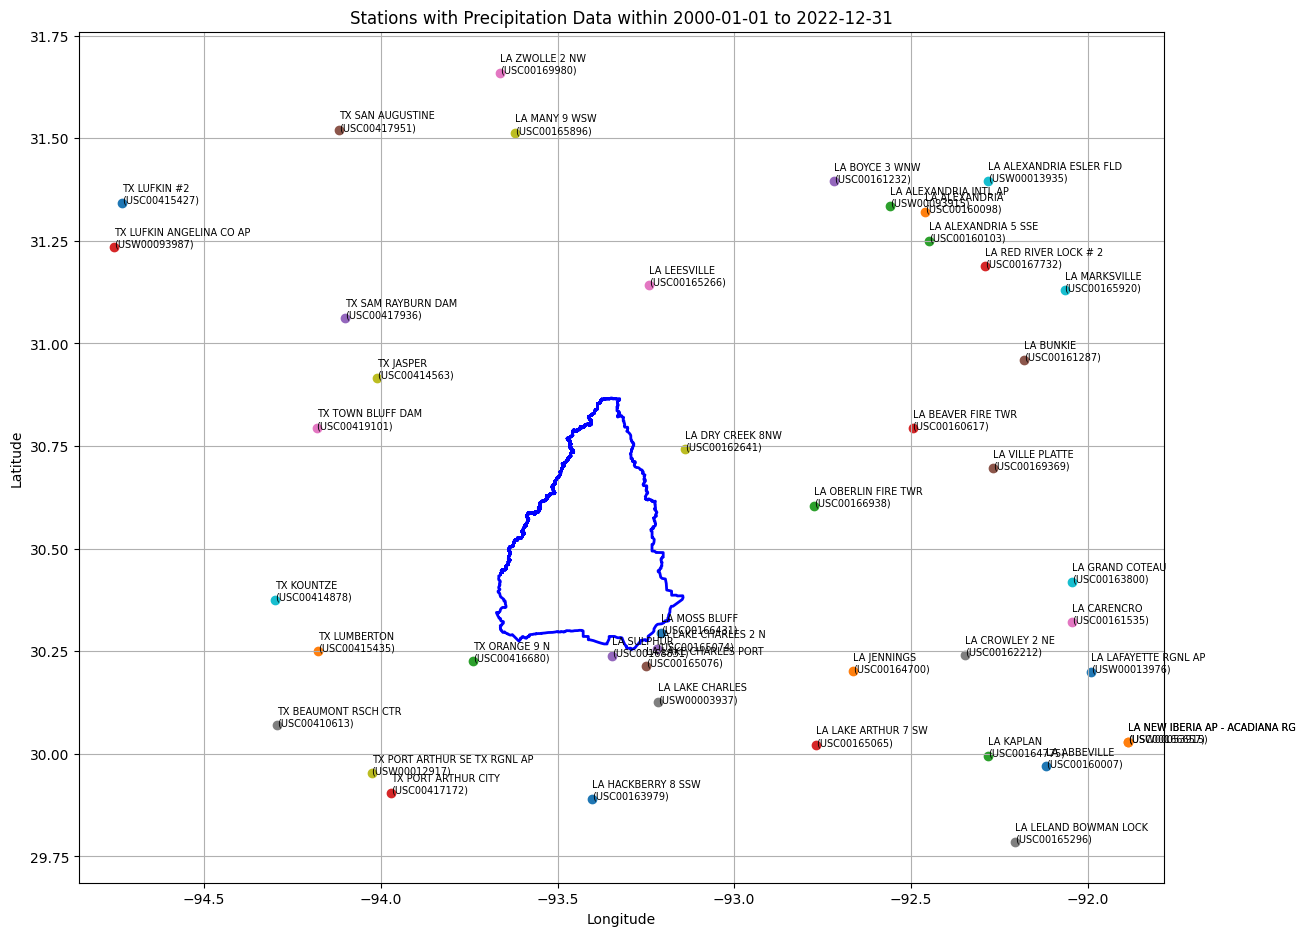

In [9]:
#9 Plot the Watershed Outline and All Stations with Precipitation Data within the Time Period

# Create a new figure and axis
figb, ax = plt.subplots(figsize=(14, 14))

# Ensure the CRS is WGS 84
if boundary_gdf.crs != "EPSG:4326":
    boundary_gdf = boundary_gdf.to_crs(epsg=4326)

# Plot the watershed boundary
boundary_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

# Initialize lists to store all latitudes and longitudes
all_lats = []
all_lons = []

# Plot each station
for station_id, station_data in filtered_dataframes_dict.items():
    # Filter the station data to only include rows within the time period
    filtered_station_data = station_data[(station_data['DATE'] >= pd.Timestamp(timeperiod_start)) & (station_data['DATE'] <= pd.Timestamp(timeperiod_end))]
    
    # Check if the filtered station data has any precipitation data
    if not filtered_station_data['PRCP'].isna().all():
        # Extract the first row of the dataframe for the station's coordinates and name
        first_row = filtered_station_data.iloc[0]
        lat = float(first_row['LATITUDE'])
        lon = float(first_row['LONGITUDE'])
        
        name_part = f"{first_row['NAME'].split(',')[0]}\n({first_row['STATION']})"


        
        # Check if the coordinates are within the valid range
        if not (-90 <= lat <= 90 and -180 <= lon <= 180):
            print(f"Invalid coordinates for station {station_id}: Latitude = {lat}, Longitude = {lon}")
            continue
        
        # Add the coordinates to the lists
        all_lats.append(lat)
        all_lons.append(lon)
        
        # Plot the station
        ax.scatter(lon, lat)
        ax.text(lon, lat, name_part, fontsize=7)


# Compare Precipitation Data Limits to Watershed Boundary Limits
boundary_coords = boundary_gdf.geometry[0].exterior.coords.xy

# Check data coverage
if min(boundary_coords[1]) < min(all_lats) or max(boundary_coords[1]) > max(all_lats) or min(boundary_coords[0]) < min(all_lons) or max(boundary_coords[0]) > max(all_lons):
    print("Inadequate Data Coverage")
else:
    print("Adequate Data Coverage")

all_lats.extend(boundary_coords[1])
all_lons.extend(boundary_coords[0])

# Display max and min of latitudes and longitudes
print("Max and Min of all_lats and all_lons")
print(max(all_lats))
print(min(all_lats))
print(max(all_lons))
print(min(all_lons))

# Set the axis limits
ax.set_xlim([min(all_lons)-0.1, max(all_lons)+0.1])
ax.set_ylim([min(all_lats)-0.1, max(all_lats)+0.1])

# Set the title and labels
plt.title(f'Stations with Precipitation Data within {timeperiod_start} to {timeperiod_end}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add grid
plt.grid(True)

# Show the plot
plt.show()


In [10]:
#10 Create new cleaned dataframe with all precipitation data within time period, then fill missing values

import pandas as pd
import matplotlib.pyplot as plt

# Check if 'PRCP' column is present and filter those dataframes
print("Check if 'PRCP' column is present and filter those dataframes")
cleaned_dataframes_dict = {station_id: data for station_id, data in filtered_dataframes_dict.items() 
                           if 'PRCP' in data.columns}
print("cleaned_dataframes_dict:")

# Initialize an empty DataFrame with defined columns
print("Initialize an empty DataFrame with defined columns")
columns = ["STATION", "NAME", "DATE", "LATITUDE", "LONGITUDE", "PRCP"]
prcp_time_series_df = pd.DataFrame(columns=columns)

# Iterate through each station and its data in the cleaned dictionary
for station_id, station_data in cleaned_dataframes_dict.items():
    print(f"Processing station {station_id}")
    # Filter the station data for the time period of interest
    mask = (station_data['DATE'] >= pd.Timestamp(timeperiod_start)) & \
           (station_data['DATE'] <= pd.Timestamp(timeperiod_end))
    filtered_station_data = station_data[mask].copy()
    
    # Check if there is any data within the time period
    if not filtered_station_data.empty:
        # Ensure consistent dtypes and columns before concatenation
        # This could involve checking for NA columns, converting dtypes, etc.
        
        # Append the filtered data to the consolidated DataFrame
        prcp_time_series_df = pd.concat([prcp_time_series_df, filtered_station_data], ignore_index=True)

clear_output()

# Display the head of the consolidated DataFrame
display(prcp_time_series_df.head())

# write prcp_time_series_df to csv
prcp_time_series_df.to_csv(csv_precipitation_file_path, index=False)




,STATION,NAME,DATE,LATITUDE,LONGITUDE,PRCP
0,USC00160007,LA ABBEVILLE,2000-01-01,29.9689,-92.1169,0
1,USC00160007,LA ABBEVILLE,2000-01-02,29.9689,-92.1169,0
2,USC00160007,LA ABBEVILLE,2000-01-03,29.9689,-92.1169,0
3,USC00160007,LA ABBEVILLE,2000-01-04,29.9689,-92.1169,51
4,USC00160007,LA ABBEVILLE,2000-01-05,29.9689,-92.1169,0


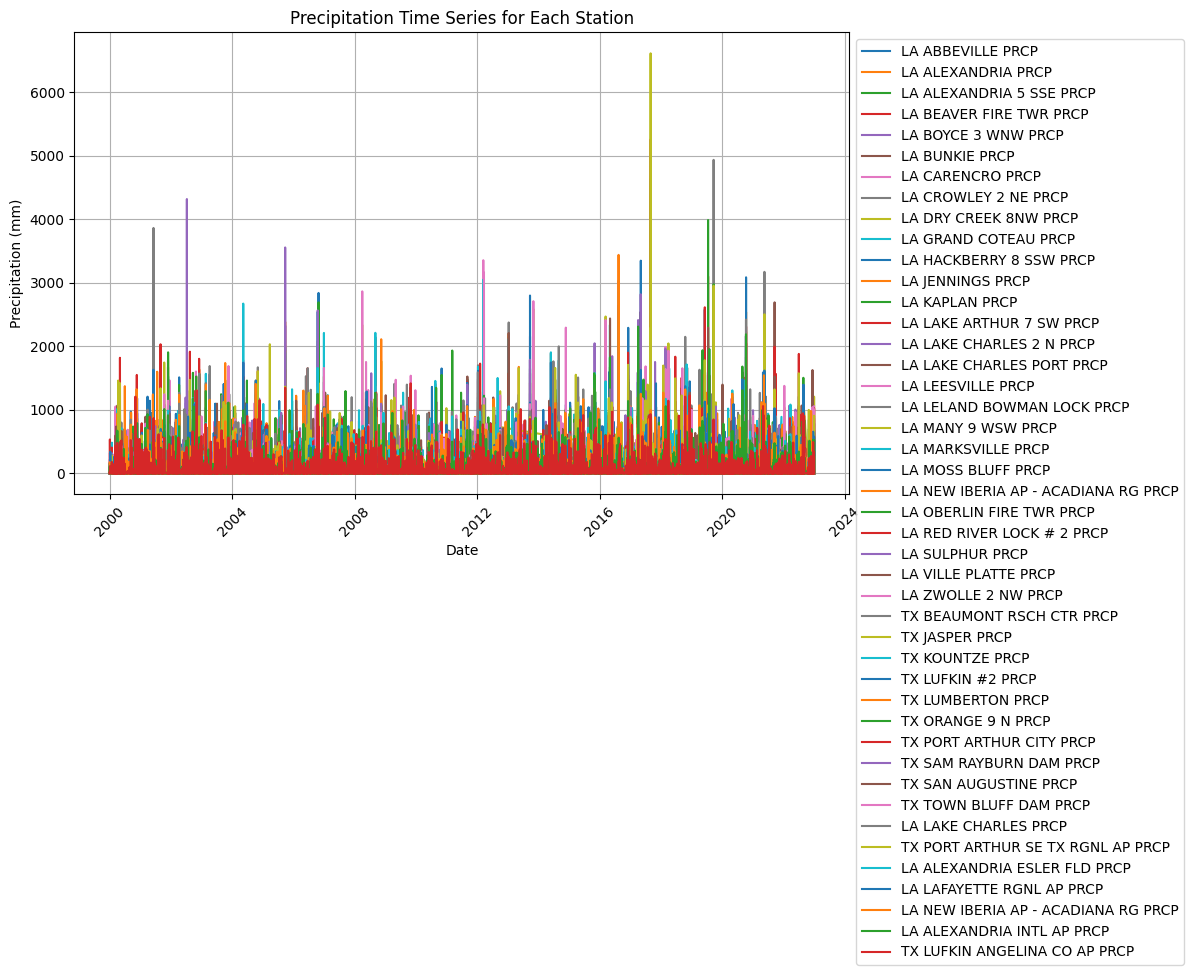

In [11]:
#11 Plot the Precipitation Time Series for All Stations (Bulk Plot)
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each station and plot its time series
for station_id, station_data in prcp_time_series_df.groupby('STATION'):
    
    # Plot PRCP
    ax.plot(pd.to_datetime(station_data['DATE']), station_data['PRCP'], 
            label=f"{station_data['NAME'].iloc[0]} PRCP")

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Time Series for Each Station')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent clipping and make room for the legend
#plt.tight_layout()
#plt.subplots_adjust(right=0.75)

# Show the plot
plt.show()
